# Blood Pressure from PPG signal

In this notebook, you should solve the problem in Task 4 (blood pressure estimation from PPG signal) in the first assignment (<a href="http://kovan.ceng.metu.edu.tr/~sinan/DL/HW1.html">HW1</a>) using a CNN architecture that you should construct using the layers and the network you developed in this HW.

The notebook is intentionally composed of only this cell. You can copy-paste any text, data, cell, or code that you developed in this HW or HW1. You can add as many cells as you want. You can create files on the disk as freely as you like.

In [222]:
import random
import numpy as np
from utils import load_BP_dataset
import matplotlib.pyplot as plt
from scipy import signal

from cs231n.fast_layers import *
from cs231n.layers import *
from cs231n.classifier_trainer import ClassifierTrainer
from cs231n.gradient_check import eval_numerical_gradient
from cs231n.classifiers.convnet import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# taken from HW1
def get_data(datafile, training_ratio=0.9, test_ratio=0.06, val_ratio=0.01):
  # Load the PPG training data 
  X, y = load_BP_dataset(datafile)
    
  ################################################################
  # TODO: Split the data into training, validation and test sets #
  ################################################################
  X_train = X[0:int(X.shape[0]*training_ratio)]
  y_train = y[0:int(y.shape[0]*training_ratio)]
  X_val = X[int(X.shape[0]*training_ratio):int(X.shape[0]*(training_ratio+val_ratio))]
  y_val = y[int(y.shape[0]*training_ratio):int(y.shape[0]*(training_ratio+val_ratio))]
  X_test = X[int(X.shape[0]*(training_ratio+val_ratio)):int(X.shape[0]*(training_ratio+val_ratio+test_ratio))]
  y_test = y[int(y.shape[0]*(training_ratio+val_ratio)):int(y.shape[0]*(training_ratio+val_ratio+test_ratio))]
  #########    END OF YOUR CODE    ###############################
  ################################################################
  
  return X_train, y_train, X_val, y_val, X_test, y_test

datafile = 'Part_1.mat' #TODO: PATH to your data file
input_size = 1000 # TODO: Size of the input of the network

X_train, y_train, X_val, y_val, X_test, y_test = get_data(datafile)
print "Number of instances in the training set: ", len(X_train)
print "Number of instances in the validation set: ", len(X_val)
print "Number of instances in the testing set: ", len(X_test)

Number of instances in the training set:  74496600
Number of instances in the validation set:  827740
Number of instances in the testing set:  4966440


In [3]:
X_train_norm = X_train[0:8000]
X_test_norm = X_test[10000:12000]
X_val_norm = X_train[8000:9100]
y_train_norm = y_train[0:8000]
y_test_norm = y_train[10000:12000]
y_val_norm = y_train[8000:9100]

In [5]:
def preparepeaks(y):
    peakind = signal.find_peaks_cwt(y, np.arange(1,10))
    max_avg = np.mean(y[peakind])
    peakind = signal.find_peaks_cwt(-y, np.arange(1,10))
    min_avg = np.mean(y[peakind])
    return max_avg, min_avg


In [92]:
stride = 2
y_train_peaks = np.zeros(((((y_train_norm.shape[0]-input_size)/stride)+1),2))
for i in range(y_train_peaks.shape[0]):
    y_train_peaks[i,:] = preparepeaks(y_train_norm[stride*i:(stride*i)+input_size])
    
y_val_peaks = np.zeros(((((y_val_norm.shape[0]-input_size)/stride)+1),2))
for i in range(y_val_peaks.shape[0]):
    y_val_peaks[i,:] = preparepeaks(y_val_norm[stride*i:(stride*i)+input_size])
    
y_test_peaks = np.zeros(((((y_test_norm.shape[0]-input_size)/stride)+1),2))
for i in range(y_val_peaks.shape[0]):
    y_test_peaks[i,:] = preparepeaks(y_test_norm[stride*i:(stride*i)+input_size])
    
X_train_final = np.zeros(((((X_train_norm.shape[0]-input_size)/stride)+1),input_size))
for i in range(X_train_final.shape[0]):
    X_train_final[i,:] = X_train_norm[stride*i:(stride*i)+input_size]    

X_val_final = np.zeros(((((X_val_norm.shape[0]-input_size)/stride)+1),input_size))
for i in range(X_val_final.shape[0]):
    X_val_final[i,:] = X_val_norm[stride*i:(stride*i)+input_size]
    
X_test_final = np.zeros(((((X_test_norm.shape[0]-input_size)/stride)+1),input_size))
for i in range(X_test_final.shape[0]):
    X_test_final[i,:] = X_test_norm[stride*i:(stride*i)+input_size]

In [93]:
print X_train_final.shape
print y_train_peaks.shape
print X_val_final.shape
print y_val_peaks.shape
print X_test_final.shape
print y_test_peaks.shape

(3501, 1000)
(3501, 2)
(51, 1000)
(51, 2)
(501, 1000)
(501, 2)


In [94]:
# Adding dimensions, N,C,H,W = X.shape
X_train_fin = X_train_final[:,None,None,:]
X_val_fin = X_val_final[:,None,None,:]
X_test_fin = X_test_final[:,None,None,:]

# Sanity Check

New network is created under convnet.py
In given functions, paddings are same for height and width. This expands our 1 row data to filter_size row data. Seperating padding height and width needs too much effort considering previous tasks should also be changed. Therefore padding is omitted in new networks.

In [85]:

model = BP_init_two_layer_convnet(input_shape=(1,1,1000), num_classes=2)

X = np.random.randn(100, 1, 1, 1000) # 100 samples, length 1000
y = np.random.randn(100,2) # random two targets

loss, _ = BP_two_layer_convnet(X, model, y, reg=0)

print 'Sanity check loss (no regularization): ', loss

# Sanity check: Loss should go up when you add regularization
loss, _ = BP_two_layer_convnet(X, model, y, reg=1)
print 'Sanity check loss (with regularization): ', loss

Sanity check loss (no regularization):  0.9624418445233408
Sanity check loss (with regularization):  0.9783956032191613


# Training

## Regression Trainer

In previous tasks, we were given a classifier trainer, which we used when classifying objects with convnets. But loss function of classifier, softmax, is not proper for regression tasks. I created regression trainer, draft is taken from classifier trainer, and modified with respect to our network trainer in HW1. Softmax loss is replaced by MSE loss, and accuracy calculations replaced by error calculations. Now our ConvNets are ready for regression problem.

## BP_two_layer_convnet

The networks in convnet.py also returns loss for the trainer. We have different loss function for this task, so we need to change networks loss functions. This network is same with two layer convnet with MSE loss function.

## Results

List of recorded results with parameters. 
-  Simple Two layer conv+relu+pool+affine+mse  
  
loss_function = BP_two_layer_convnet  
model = BP_init_two_layer_convnet(weight_scale = 1e-2, input_shape=(1,1,1000), num_classes=2)  
reg = 0.00001  
learning_rate = 0.001  
momentum = 0.9  
batch_size = 50  
learning_rate_decay = 0.95  
num_epochs = 15  
update='momentum'  
  
Iteration 1050:  
loss 1078.240036, train error: 24.442630, val error 3.361860, lr 4.632912e-04  
finished optimization. best validation error: 3.235613  
  
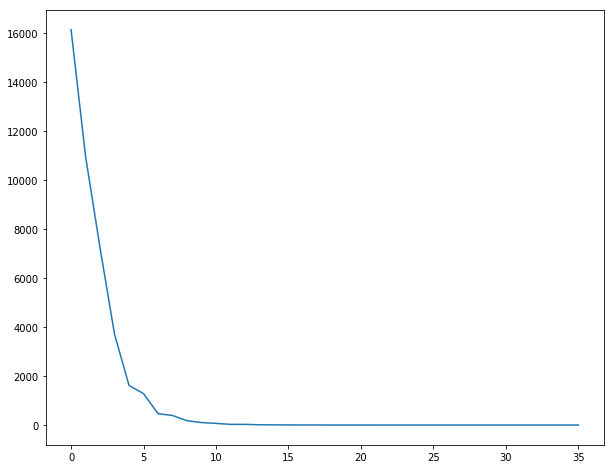

-  Same Network, 'sgd' instead of 'momentum' update  
  
loss 2234.721493, train error: 4456.317005, val error 4377.287332, lr 4.632912e-04  

Looks like performed poorly but actually graph looks promising. Needs more epoch or different hyperparameters.

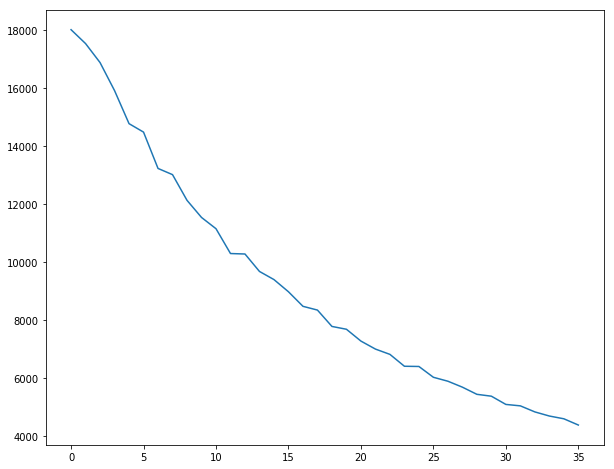

-  Same Network, 'rmsprop'

loss 13.220708, train error: 25.053830, val error 2.167887, lr 4.632912e-04
finished optimization. best validation error: 0.798466

This one looks great, loss is also decreased significantly.



#### RMSProp looks like it performs better, I will continue with that. Error is better than the HW1 network, graphs looks like network has enough capacity. I increased the data size and tweaked other parametes and experimented more on this network.

-  Same Network, 'rmsprop' reg = 0.001

loss 88946.107092, train error: 25.197895, val error 21.515113, lr 4.632912e-04
finished optimization. best validation error: 21.515113

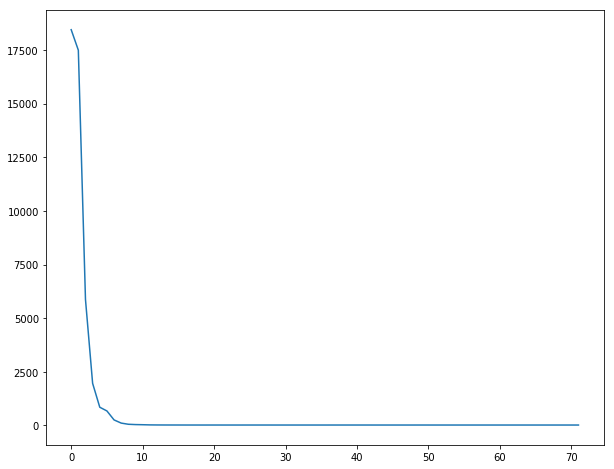

-  reg = 0.0001

loss 15.573377, train error: 30.059184, val error 30.963822, lr 4.632912e-04
finished optimization. best validation error: 26.481678

When regularization is increased, loss explodes due to |W.W| term but validation error can decrease.

-  Same Network, Same Network, 'rmsprop''rmsprop' filter_size = 15 
loss 17.860381, train error: 30.093083, val error 31.414324, lr 4.632912e-04

-  lr_decay = 0.99 weight_scale = 1e-3

loss 18.333837, train error: 36.724310, val error 28.350437, lr 8.600584e-04

- lr_decay = 0.96 filter_size = 33
loss 19.220876, train error: 32.156908, val error 32.002429, lr 4.420024e-04

-  filter_size = 15, num_filters = 64

loss 21.493021, train error: 35.206265, val error 57.322023, lr 4.420024e-04

In this one, best val_err = 27, end up 57, overfitted with tihs many filters. 

-  filter_size = 201

loss 46.428184, train error: 86.091897, val error 141.798755, lr 6.648326e-04 best validation error: 29.426666

In [115]:
from cs231n.regression_trainer import RegressionTrainer

In [224]:
loss_function = BP_two_layer_convnet
model = BP_init_two_layer_convnet(weight_scale = 1e-2,
                                  input_shape=(1,1,1000),
                                  num_classes=2)
reg = 0.0001
learning_rate = 0.001
momentum = 0.9
batch_size = 50
learning_rate_decay = 0.95
num_epochs = 15
update='momentum'
trainer = RegressionTrainer()
best_model, loss_history, train_err_history, val_err_history = trainer.train(
          X_train_fin, y_train_peaks, X_val_fin, y_val_peaks, model, loss_function=loss_function,
          reg=reg, learning_rate=learning_rate, momentum=momentum,learning_rate_decay=learning_rate_decay,
          update=update,num_epochs=num_epochs, batch_size=batch_size, 
          acc_frequency=50, verbose=True)

starting iteration  0
Finished epoch 0 / 15: loss 9808.710049, train error: 18197.210117, val error 18446.116954, lr 1.000000e-03
starting iteration  20
starting iteration  40
Finished epoch 0 / 15: loss 96400.255563, train error: 17258.164650, val error 17490.381501, lr 1.000000e-03
starting iteration  60
starting iteration  80
starting iteration  100
Finished epoch 0 / 15: loss 92255.026590, train error: 5708.734478, val error 5873.290850, lr 1.000000e-03
starting iteration  120
starting iteration  140
Finished epoch 0 / 15: loss 90255.539548, train error: 1876.222085, val error 1963.920863, lr 1.000000e-03
starting iteration  160
starting iteration  180
Finished epoch 1 / 15: loss 89668.916486, train error: 789.128979, val error 851.340589, lr 9.500000e-04
starting iteration  200
Finished epoch 1 / 15: loss 89577.328694, train error: 642.660275, val error 677.829708, lr 9.500000e-04
starting iteration  220
starting iteration  240
Finished epoch 1 / 15: loss 89371.168254, train error

starting iteration  2140
Finished epoch 11 / 15: loss 89007.938922, train error: 26.056408, val error 21.526831, lr 5.688001e-04
starting iteration  2160
starting iteration  2180
starting iteration  2200
Finished epoch 11 / 15: loss 89004.565642, train error: 25.321238, val error 21.547839, lr 5.688001e-04
starting iteration  2220
starting iteration  2240
Finished epoch 11 / 15: loss 89000.591427, train error: 25.579272, val error 21.600038, lr 5.688001e-04
starting iteration  2260
Finished epoch 12 / 15: loss 88994.604505, train error: 25.211368, val error 21.563624, lr 5.403601e-04
starting iteration  2280
starting iteration  2300
Finished epoch 12 / 15: loss 88999.449795, train error: 24.686571, val error 21.529276, lr 5.403601e-04
starting iteration  2320
starting iteration  2340
Finished epoch 12 / 15: loss 88993.555367, train error: 24.897848, val error 21.596770, lr 5.403601e-04
starting iteration  2360
starting iteration  2380
starting iteration  2400
Finished epoch 12 / 15: lo

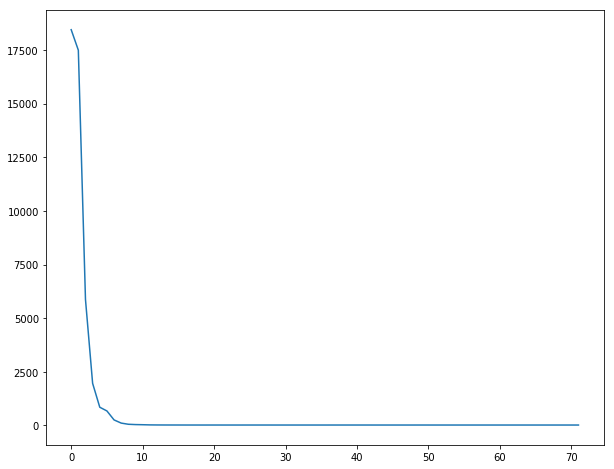

In [225]:
plt.plot(val_err_history)

In [149]:
loss_function = BP_two_layer_convnet
model = BP_init_two_layer_convnet(weight_scale = 1e-2,
                                  input_shape=(1,1,1000),
                                  num_classes=2)
reg = 0.00001
learning_rate = 0.001
momentum = 0.9
batch_size = 50
learning_rate_decay = 0.95
num_epochs = 15
update='rmsprop'
trainer = RegressionTrainer()
best_model, loss_history, train_err_history, val_err_history = trainer.train(
          X_train_fin, y_train_peaks, X_val_fin, y_val_peaks, model, loss_function=loss_function,
          reg=reg, learning_rate=learning_rate, momentum=momentum,learning_rate_decay=learning_rate_decay,
          update=update,num_epochs=num_epochs, batch_size=batch_size, 
          acc_frequency=50, verbose=True)

starting iteration  0
Finished epoch 0 / 15: loss 9542.495308, train error: 16732.797543, val error 16611.811072, lr 1.000000e-03
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
Finished epoch 0 / 15: loss 13.428807, train error: 28.605778, val error 2.801368, lr 1.000000e-03
starting iteration  60
Finished epoch 1 / 15: loss 16.956260, train error: 27.667419, val error 1.916843, lr 9.500000e-04
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  100
Finished epoch 1 / 15: loss 15.519919, train error: 30.329899, val error 1.890391, lr 9.500000e-04
starting iteration  110
starting iteration  120
starting iteration  130
Finished epoch 2 / 15: loss 12.420174, train error: 28.428793, val error 2.373350, lr 9.025000e-04
starting iteration  140
starting iteration  150
Finished epoch 2 / 15: loss 10.996460, train error: 30.154477, val error 2.982978, lr 9.025000e-04
starting iteration  160


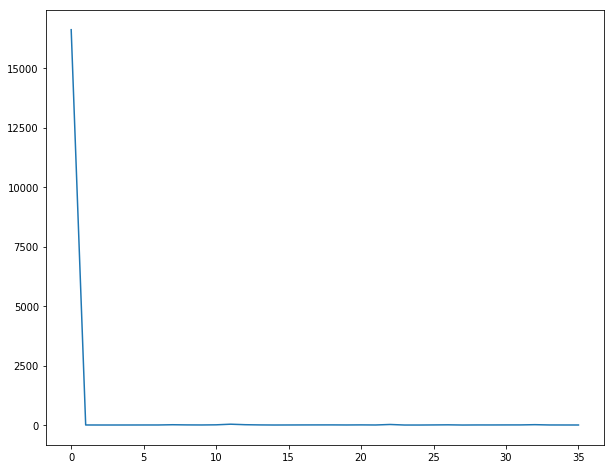

In [151]:
plt.plot(val_err_history)

In [173]:
# Let's give more data. Val/Train ratio is increased,
# which will effect val_error 

X_train_norm = X_train[0:20000]
X_val_norm = X_train[20000:23000]
y_train_norm = y_train[0:20000]
y_val_norm = y_train[20000:23000]
X_test_norm = X_test[23000:24050]
y_test_norm = y_train[23000:24050]

In [163]:
# prepare new data

stride = 2
y_train_peaks = np.zeros(((((y_train_norm.shape[0]-input_size)/stride)+1),2))
for i in range(y_train_peaks.shape[0]):
    y_train_peaks[i,:] = preparepeaks(y_train_norm[stride*i:(stride*i)+input_size])
    
y_val_peaks = np.zeros(((((y_val_norm.shape[0]-input_size)/stride)+1),2))
for i in range(y_val_peaks.shape[0]):
    y_val_peaks[i,:] = preparepeaks(y_val_norm[stride*i:(stride*i)+input_size])
    
X_train_final = np.zeros(((((X_train_norm.shape[0]-input_size)/stride)+1),input_size))
for i in range(X_train_final.shape[0]):
    X_train_final[i,:] = X_train_norm[stride*i:(stride*i)+input_size]    

X_val_final = np.zeros(((((X_val_norm.shape[0]-input_size)/stride)+1),input_size))
for i in range(X_val_final.shape[0]):
    X_val_final[i,:] = X_val_norm[stride*i:(stride*i)+input_size]
    
X_test_final = np.zeros(((((X_test_norm.shape[0]-input_size)/stride)+1),input_size))
for i in range(X_test_final.shape[0]):
    X_test_final[i,:] = X_test_norm[stride*i:(stride*i)+input_size]
    
y_test_peaks = np.zeros(((((y_test_norm.shape[0]-input_size)/stride)+1),2))
for i in range(y_test_peaks.shape[0]):
    y_test_peaks[i,:] = preparepeaks(y_test_norm[stride*i:(stride*i)+input_size])

IndexError: index 1 is out of bounds for axis 0 with size 1

In [177]:
X_train_fin = X_train_final[:,None,None,:]
X_val_fin = X_val_final[:,None,None,:]
X_test_fin = X_test_final[:,None,None,:]

In [227]:
print X_train_fin.shape
print y_train_peaks.shape
print X_val_fin.shape
print y_val_peaks.shape
print X_test_fin.shape
print y_test_peaks.shape

(9501, 1, 1, 1000)
(9501, 2)
(1001, 1, 1, 1000)
(1001, 2)
(26, 1, 1, 1000)
(26, 2)


In [208]:
loss_function = BP_two_layer_convnet
model = BP_init_two_layer_convnet(weight_scale = 1e-2,
                                  input_shape=(1,1,1000),
                                  num_classes=2,
                                  filter_size = 15)
reg = 0.00001
learning_rate = 0.001
momentum = 0.9
batch_size = 50
learning_rate_decay = 0.95
num_epochs = 15
update='rmsprop'
trainer = RegressionTrainer()
best_model, loss_history, train_err_history, val_err_history = trainer.train(
          X_train_fin, y_train_peaks, X_val_fin, y_val_peaks, model, loss_function=loss_function,
          reg=reg, learning_rate=learning_rate, momentum=momentum,learning_rate_decay=learning_rate_decay,
          update=update,num_epochs=num_epochs, batch_size=batch_size, 
          acc_frequency=50, verbose=True)

starting iteration  0
Finished epoch 0 / 15: loss 9884.764061, train error: 14542.176572, val error 14660.284012, lr 1.000000e-03
starting iteration  20
starting iteration  40
Finished epoch 0 / 15: loss 31.737842, train error: 69.684156, val error 39.125107, lr 1.000000e-03
starting iteration  60
starting iteration  80
starting iteration  100
Finished epoch 0 / 15: loss 42.590187, train error: 94.329668, val error 146.367349, lr 1.000000e-03
starting iteration  120
starting iteration  140
Finished epoch 0 / 15: loss 13.532042, train error: 31.192031, val error 35.333924, lr 1.000000e-03
starting iteration  160
starting iteration  180
Finished epoch 1 / 15: loss 39.825270, train error: 88.896741, val error 54.196709, lr 9.500000e-04
starting iteration  200
Finished epoch 1 / 15: loss 14.041913, train error: 32.904720, val error 35.972773, lr 9.500000e-04
starting iteration  220
starting iteration  240
Finished epoch 1 / 15: loss 18.672277, train error: 31.949823, val error 38.738903, l

starting iteration  2200
Finished epoch 11 / 15: loss 24.701345, train error: 40.429856, val error 27.998579, lr 5.688001e-04
starting iteration  2220
starting iteration  2240
Finished epoch 11 / 15: loss 29.620239, train error: 47.580881, val error 29.680577, lr 5.688001e-04
starting iteration  2260
Finished epoch 12 / 15: loss 25.351707, train error: 49.769221, val error 30.129517, lr 5.403601e-04
starting iteration  2280
starting iteration  2300
Finished epoch 12 / 15: loss 14.687016, train error: 32.021857, val error 38.176076, lr 5.403601e-04
starting iteration  2320
starting iteration  2340
Finished epoch 12 / 15: loss 26.817772, train error: 55.256582, val error 86.629898, lr 5.403601e-04
starting iteration  2360
starting iteration  2380
starting iteration  2400
Finished epoch 12 / 15: loss 17.533112, train error: 31.965248, val error 37.424245, lr 5.403601e-04
starting iteration  2420
starting iteration  2440
Finished epoch 12 / 15: loss 15.734430, train error: 35.335015, val e